In [1]:
import os
import sys
import pathlib
import numpy as np
import torch
import matplotlib.pyplot as plt
from typing import Dict, Any

from openpi.training import config as _config
from openpi.training import data_loader as _data_loader
from openpi.training import checkpoints as _checkpoints
from openpi.policies import policy_config
from openpi.models import model as _model
from openpi import transforms as _transforms

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["TORCH_DISABLE_DYNAMO"] = "1"
os.environ["PYTORCH_JIT"] = "0"

print("✅ 导入完成")


/home/wyz/miniconda3/envs/pi0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 导入完成


In [2]:
def load_finetuned_policy():
    """加载微调后的 checkpoint"""
    print("Loading finetuned policy checkpoint...")
    config = _config.get_config("pi05_pick_blue_bottle_libero_downsample4x")
    ckpt = "/home/wyz/openpi/checkpoints/pi05_pick_blue_bottle_libero_downsample4x/pick_blue_bottle_finetune/20000"
    
    def _no_compile(x, *args, **kwargs):
        return x
    torch.compile = _no_compile
    
    try:
        torch.jit._state.disable()
    except Exception:
        pass
    
    policy = policy_config.create_trained_policy(config, ckpt, pytorch_device="cuda:0")
    print("✅ Policy loaded:", type(policy))
    return policy

# 加载模型
policy = load_finetuned_policy()


Loading finetuned policy checkpoint...
✅ Policy loaded: <class 'openpi.policies.policy.Policy'>


In [13]:
def load_training_sample(config_name: str = "pi05_pick_blue_bottle_libero_downsample4x", sample_index: int = 0, local_data_path: str = None):
    """从训练数据集中加载一个样本（从本地路径加载）"""
    print(f"Loading training dataset: {config_name}")
    config = _config.get_config(config_name)
    
    data_config = config.data.create(config.assets_dirs, config.model)
    
    # 如果提供了本地路径，使用本地路径；否则使用 repo_id
    if local_data_path is None:
        # 尝试从默认缓存路径加载
        local_data_path = f"/home/wyz/.cache/huggingface/lerobot/{data_config.repo_id}"
    
    print(f"Loading dataset from local path: {local_data_path}")
    
    try:
        from lerobot.common.datasets.lerobot_dataset import LeRobotDatasetMetadata
        
        # 尝试从本地路径加载 metadata
        try:
            dataset_meta = LeRobotDatasetMetadata(data_config.repo_id, data_dir=local_data_path)
        except:
            # 如果失败，尝试使用默认路径
            dataset_meta = LeRobotDatasetMetadata(data_config.repo_id)
        
        # 从本地路径加载数据集
        from datasets import load_dataset
        
        # 查找 data 目录下的所有 parquet 文件（递归查找）
        data_dir = pathlib.Path(local_data_path) / "data"
        if not data_dir.exists():
            # 尝试直接使用 local_data_path
            data_dir = pathlib.Path(local_data_path)
        
        # 递归查找所有 parquet 文件
        parquet_files = list(data_dir.rglob("*.parquet"))
        if parquet_files:
            # 如果有多个 parquet 文件，加载所有
            print(f"Found {len(parquet_files)} parquet files")
            # 按文件名排序以确保顺序一致
            parquet_files = sorted(parquet_files)
            hf_dataset = load_dataset("parquet", data_files=[str(f) for f in parquet_files], split="train")
        else:
            # 尝试直接加载目录
            try:
                hf_dataset = load_dataset("parquet", data_dir=str(data_dir), split="train")
            except Exception as e:
                # 如果失败，尝试使用 repo_id（会从缓存加载）
                print(f"Warning: Could not load from {data_dir}: {e}")
                print(f"Trying repo_id {data_config.repo_id}")
                hf_dataset = load_dataset(data_config.repo_id, split="train")
        
        print(f"Dataset length: {len(hf_dataset)}")
        
        # 获取样本
        raw_sample = hf_dataset[sample_index]
        
        # 手动构建 action sequence
        action_horizon = config.model.action_horizon
        fps = dataset_meta.fps
        
        # 获取当前 episode 的所有帧
        episode_idx = raw_sample.get("episode_index", sample_index)
        episode_frames = []
        for i in range(len(hf_dataset)):
            sample = hf_dataset[i]
            if sample.get("episode_index") == episode_idx:
                episode_frames.append((i, sample))
        
        # 找到当前帧在 episode 中的位置
        current_frame_idx = None
        for idx, (i, frame) in enumerate(episode_frames):
            if i == sample_index:
                current_frame_idx = idx
                break
        
        if current_frame_idx is None:
            current_frame_idx = 0
        
        # 构建 action sequence（从当前帧开始，获取 action_horizon 个步骤）
        actions_list = []
        for i in range(action_horizon):
            frame_idx = current_frame_idx + i
            if frame_idx < len(episode_frames):
                _, frame = episode_frames[frame_idx]
                action = frame.get("actions")
                if action is not None:
                    if isinstance(action, np.ndarray):
                        actions_list.append(action)
                    elif hasattr(action, 'numpy'):
                        actions_list.append(action.numpy())
                    else:
                        actions_list.append(np.array(action))
                else:
                    # 使用零 action
                    if actions_list:
                        actions_list.append(actions_list[-1])
                    else:
                        actions_list.append(np.zeros(7))
            else:
                # 超出范围，重复最后一个
                if actions_list:
                    actions_list.append(actions_list[-1])
                else:
                    actions_list.append(np.zeros(7))
        
        actions_sequence = np.array(actions_list)
        
        # 准备样本数据
        # 注意：RepackTransform 期望原始键名（如 "image"），而不是 "observation/image"
        # RepackTransform 会将它们映射到 "observation/image"
        sample_dict = {}
        
        # 处理图像（使用原始键名）
        for key in ["image", "wrist_image"]:
            if key in raw_sample:
                img = raw_sample[key]
                if hasattr(img, 'numpy'):
                    sample_dict[key] = img.numpy()
                elif isinstance(img, np.ndarray):
                    sample_dict[key] = img
                else:
                    sample_dict[key] = np.array(img)
        
        # 处理 state（使用原始键名）
        if "state" in raw_sample:
            state = raw_sample["state"]
            if hasattr(state, 'numpy'):
                sample_dict["state"] = state.numpy()
            elif isinstance(state, np.ndarray):
                sample_dict["state"] = state
            else:
                sample_dict["state"] = np.array(state)
        
        # 处理 prompt
        if "task" in raw_sample:
            prompt = raw_sample["task"]
            if isinstance(prompt, bytes):
                prompt = prompt.decode('utf-8')
            sample_dict["prompt"] = str(prompt)
        elif "prompt" in raw_sample:
            prompt = raw_sample["prompt"]
            if isinstance(prompt, bytes):
                prompt = prompt.decode('utf-8')
            sample_dict["prompt"] = str(prompt)
        else:
            sample_dict["prompt"] = "pick blue bottle"
        
        # 添加 actions 到 sample_dict（在应用 transforms 之前）
        # 注意：这里的 actions 是原始格式，会在后续的 transforms 中处理
        sample_dict["actions"] = actions_sequence
        
        # 应用 transforms（简化版，只应用必要的）
        # repack_transforms
        for transform in data_config.repack_transforms.inputs:
            sample_dict = transform(sample_dict)
        
        # data_transforms.inputs
        for transform in data_config.data_transforms.inputs:
            sample_dict = transform(sample_dict)
        
        # 加载归一化统计信息
        ckpt_dir = pathlib.Path("/home/wyz/openpi/checkpoints/pi05_pick_blue_bottle_libero_downsample4x/pick_blue_bottle_finetune/20000")
        norm_stats = _checkpoints.load_norm_stats(ckpt_dir / "assets", data_config.asset_id)
        
        # 归一化
        normalize_transform = _transforms.Normalize(norm_stats, use_quantiles=data_config.use_quantile_norm)
        sample_dict = normalize_transform(sample_dict)
        
        # model_transforms.inputs
        for transform in data_config.model_transforms.inputs:
            sample_dict = transform(sample_dict)
        
        # actions 已经包含在 sample_dict 中，会随着其他数据一起被 transform
        # 不需要单独处理
        
        print(f"✅ Loaded and processed sample {sample_index}")
        print(f"  Sample keys: {list(sample_dict.keys())}")
        if "actions" in sample_dict:
            print(f"  Actions shape: {sample_dict['actions'].shape}")
        
        # 保存原始 state（8 维），用于推理
        # 从原始数据中获取 state（在 transforms 之前）
        raw_state = None
        if "state" in raw_sample:
            raw_state = raw_sample["state"]
            if hasattr(raw_state, 'numpy'):
                raw_state = raw_state.numpy()
            elif not isinstance(raw_state, np.ndarray):
                raw_state = np.array(raw_state)
            # 确保是 1D
            if len(raw_state.shape) > 1:
                raw_state = raw_state[0]
        
        return sample_dict, config, raw_state
        
    except Exception as e:
        print(f"Error loading sample: {e}")
        import traceback
        traceback.print_exc()
        raise

# 加载训练数据样本（使用第一个样本）
sample_index = 0
local_data_path = "/home/wyz/.cache/huggingface/lerobot/your_hf_username/pick_blue_bottle_libero_downsample4x"
training_sample, train_config, raw_state = load_training_sample(sample_index=sample_index, local_data_path=local_data_path)


Loading training dataset: pi05_pick_blue_bottle_libero_downsample4x
Loading dataset from local path: /home/wyz/.cache/huggingface/lerobot/your_hf_username/pick_blue_bottle_libero_downsample4x
Found 101 parquet files
Dataset length: 8472
✅ Loaded and processed sample 0
  Sample keys: ['state', 'image', 'image_mask', 'actions', 'tokenized_prompt', 'tokenized_prompt_mask']
  Actions shape: (10, 32)


In [14]:
# 准备推理输入（使用训练数据的 state 和图像）
print("Preparing inference input from training data...")

# 从训练样本中提取输入
# 注意：训练数据中的图像可能是 torch tensor，需要转换为 numpy
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    return np.asarray(x)

# 处理图像：training_sample["image"] 是一个字典，包含 base_0_rgb, left_wrist_0_rgb 等
# 推理时需要的格式是 observation/image 和 observation/wrist_image (uint8, H, W, C)
if "image" in training_sample and isinstance(training_sample["image"], dict):
    # 从图像字典中提取
    image_dict = training_sample["image"]
    
    # 获取 base 图像（主图像）
    if "base_0_rgb" in image_dict:
        img = to_numpy(image_dict["base_0_rgb"])
    elif "base_0" in image_dict:
        img = to_numpy(image_dict["base_0"])
    else:
        # 使用第一个可用的图像
        img_key = list(image_dict.keys())[0]
        img = to_numpy(image_dict[img_key])
        print(f"Warning: Using {img_key} as base image")
    
    # 获取 wrist 图像
    if "left_wrist_0_rgb" in image_dict:
        wrist_img = to_numpy(image_dict["left_wrist_0_rgb"])
    elif "wrist_0_rgb" in image_dict:
        wrist_img = to_numpy(image_dict["wrist_0_rgb"])
    elif "left_wrist_0" in image_dict:
        wrist_img = to_numpy(image_dict["left_wrist_0"])
    else:
        # 如果没有 wrist 图像，使用 base 图像
        wrist_img = img.copy()
        print("Warning: No wrist image found, using base image")
else:
    raise ValueError(f"Expected 'image' to be a dict, but got {type(training_sample.get('image'))}. Available keys: {list(training_sample.keys())}")

# 处理图像形状和数据类型
# 图像可能是 (H, W, C) 或 (C, H, W) 或 (batch, H, W, C) 等
if len(img.shape) == 4:  # (batch, H, W, C) 或 (batch, C, H, W)
    img = img[0]  # 移除 batch 维度
if len(img.shape) == 3:
    if img.shape[0] == 3 and img.shape[0] < img.shape[2]:  # (C, H, W)
        img = img.transpose(1, 2, 0)  # 转换为 (H, W, C)
    # 否则已经是 (H, W, C)

# 转换数据类型：如果是归一化的图像（-1到1），需要转换回uint8
if img.dtype != np.uint8:
    if isinstance(img, np.ndarray):
        img_min, img_max = img.min(), img.max()
        if img_min >= -1.1 and img_max <= 1.1:
            img = ((img + 1) * 127.5).clip(0, 255).astype(np.uint8)
        else:
            img = img.clip(0, 255).astype(np.uint8)
    else:
        img = np.asarray(img).clip(0, 255).astype(np.uint8)

# 处理 wrist 图像
if len(wrist_img.shape) == 4:
    wrist_img = wrist_img[0]
if len(wrist_img.shape) == 3:
    if wrist_img.shape[0] == 3 and wrist_img.shape[0] < wrist_img.shape[2]:
        wrist_img = wrist_img.transpose(1, 2, 0)

if wrist_img.dtype != np.uint8:
    if isinstance(wrist_img, np.ndarray):
        wrist_min, wrist_max = wrist_img.min(), wrist_img.max()
        if wrist_min >= -1.1 and wrist_max <= 1.1:
            wrist_img = ((wrist_img + 1) * 127.5).clip(0, 255).astype(np.uint8)
        else:
            wrist_img = wrist_img.clip(0, 255).astype(np.uint8)
    else:
        wrist_img = np.asarray(wrist_img).clip(0, 255).astype(np.uint8)

# 获取 state（注意：推理时需要原始的 8 维 state，而不是 pad 后的 32 维）
# 使用从原始数据中保存的 raw_state（8 维）
if raw_state is not None:
    state = to_numpy(raw_state)
    print(f"Using raw state from original data: {state.shape}")
else:
    # 如果没有 raw_state，尝试从 training_sample 中获取并 slice
    state = to_numpy(training_sample["state"])
    if len(state.shape) > 1:
        state = state[0]  # 移除 batch 维度
    
    print(f"State shape before processing: {state.shape}")
    
    # 如果 state 是 32 维（已 pad），只取前 8 维（LIBERO 的原始 state 维度）
    if state.shape[0] == 32:
        state = state[:8]
        print(f"State sliced to 8 dimensions: {state.shape}")
    elif state.shape[0] != 8:
        print(f"Warning: Unexpected state dimension: {state.shape[0]}, expected 8")
        # 如果维度不对，尝试只取前 8 维
        if state.shape[0] > 8:
            state = state[:8]
            print(f"State sliced to 8 dimensions: {state.shape}")

# 确保 state 是 8 维的
assert state.shape[0] == 8, f"State must be 8-dimensional, got {state.shape[0]}"

# 获取 prompt
prompt = training_sample.get("prompt", "pick blue bottle")
if isinstance(prompt, (list, np.ndarray)):
    prompt = prompt[0] if len(prompt) > 0 else "pick blue bottle"
if isinstance(prompt, bytes):
    prompt = prompt.decode('utf-8')

inference_input = {
    "observation/image": img,
    "observation/wrist_image": wrist_img,
    "observation/state": state,
    "prompt": str(prompt),
}

print(f"Input shapes:")
print(f"  image: {inference_input['observation/image'].shape}, dtype: {inference_input['observation/image'].dtype}")
print(f"  wrist_image: {inference_input['observation/wrist_image'].shape}, dtype: {inference_input['observation/wrist_image'].dtype}")
print(f"  state: {inference_input['observation/state'].shape}, dtype: {inference_input['observation/state'].dtype}")
print(f"  prompt: {inference_input['prompt']}")

# 验证 state 维度
assert inference_input['observation/state'].shape[0] == 8, \
    f"State must be 8-dimensional for inference, got {inference_input['observation/state'].shape[0]}"

# 获取训练数据中的 action（ground truth）
training_actions = to_numpy(training_sample["actions"])
if len(training_actions.shape) > 2:
    training_actions = training_actions[0]  # 移除 batch 维度

print(f"\nTraining actions shape: {training_actions.shape}")
print(f"Training actions (first 3 steps):")
for i in range(min(3, training_actions.shape[0])):
    print(f"  Step {i}: {training_actions[i]}")


Preparing inference input from training data...
Using raw state from original data: (8,)
Input shapes:
  image: (224, 224, 3), dtype: uint8
  wrist_image: (224, 224, 3), dtype: uint8
  state: (8,), dtype: float64
  prompt: pick blue bottle

Training actions shape: (10, 32)
Training actions (first 3 steps):
  Step 0: [ 0.62591483  0.41445404  0.14159716 -0.19833545 -0.0619833   0.34809224
 -1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
  Step 1: [ 0.45267746  0.33572296  0.12471923 -0.21367614 -0.0609686   0.2715496
 -1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.      

In [15]:
# 将训练数据中的归一化 actions 反归一化，以便与推理结果比较
print("Unnormalizing training actions...")
# 训练数据中的 actions 是归一化后的，需要反归一化
# 使用 policy 的 output_transforms 来反归一化
training_actions_normalized = training_actions.copy()

# 创建一个临时的输出字典，包含归一化的 actions
# 注意：training_sample 中的键是 "state"，不是 "observation/state"（因为已经经过了 transforms）
normalized_output = {
    "state": training_sample["state"],
    "actions": training_actions_normalized,
}

# 应用 output_transforms 来反归一化（只应用 Unnormalize 和 data_transforms.outputs）
# 注意：我们需要跳过 model_transforms.outputs，因为训练数据已经是模型格式
# 实际上，policy 的 output_transforms 包含：
# - model_transforms.outputs (如 ExtractFASTActions)
# - Unnormalize
# - data_transforms.outputs (如 LiberoOutputs)
# 我们需要手动应用 Unnormalize 和 data_transforms.outputs

# 更简单的方法：直接使用 policy 的 _output_transform，但只应用部分
# 实际上，我们可以创建一个只包含 Unnormalize 的 transform
from openpi import transforms as _transforms
from openpi.training import checkpoints as _checkpoints

# 获取 norm_stats
data_config = train_config.data.create(train_config.assets_dirs, train_config.model)
if data_config.asset_id is None:
    raise ValueError("Asset id is required to load norm stats.")
ckpt_dir = pathlib.Path("/home/wyz/openpi/checkpoints/pi05_pick_blue_bottle_libero_downsample4x/pick_blue_bottle_finetune/20000")
norm_stats = _checkpoints.load_norm_stats(ckpt_dir / "assets", data_config.asset_id)

# 创建反归一化 transform（只反归一化 actions）
unnormalize_transform = _transforms.Unnormalize(norm_stats, use_quantiles=data_config.use_quantile_norm)

# 应用反归一化
unnormalized_output = unnormalize_transform(normalized_output)
training_actions_unnormalized = unnormalized_output["actions"]

# 应用 data_transforms.outputs（如 LiberoOutputs，只取前7维）
# 检查是否有 LiberoOutputs transform
if hasattr(data_config, 'data_transforms') and data_config.data_transforms.outputs:
    for transform in data_config.data_transforms.outputs:
        if 'LiberoOutputs' in str(type(transform)):
            # LiberoOutputs 只取前7维
            training_actions_unnormalized = training_actions_unnormalized[:, :7]
            break

print(f"Training actions (unnormalized) shape: {training_actions_unnormalized.shape}")
print(f"Training actions (unnormalized, first 3 steps):")
for i in range(min(3, training_actions_unnormalized.shape[0])):
    print(f"  Step {i}: {training_actions_unnormalized[i]}")

# 使用模型进行推理
print("\nRunning inference...")

# Warmup
dummy_element = {
    "observation/image": np.zeros((224, 224, 3), dtype=np.uint8),
    "observation/wrist_image": np.zeros((224, 224, 3), dtype=np.uint8),
    "observation/state": np.zeros(8, dtype=np.float32),
    "prompt": "dummy task",
}
with torch.inference_mode():
    _ = policy.infer(dummy_element)
torch.cuda.synchronize()

# 实际推理
with torch.inference_mode():
    torch.cuda.synchronize()
    inference_result = policy.infer(inference_input)
    torch.cuda.synchronize()

inferred_actions = inference_result["actions"]
print(f"✅ Inference completed")
print(f"Inferred actions shape: {inferred_actions.shape}")
print(f"Inferred actions (first 3 steps):")
for i in range(min(3, inferred_actions.shape[0])):
    print(f"  Step {i}: {inferred_actions[i]}")

# 更新 training_actions 为反归一化后的版本
training_actions = training_actions_unnormalized


Unnormalizing training actions...
Training actions (unnormalized) shape: (10, 7)
Training actions (unnormalized, first 3 steps):
  Step 0: [ 0.01172871  0.00780621  0.00188431 -0.00332189 -0.00474462  0.01802824
  0.        ]
  Step 1: [ 0.00728054  0.00456111  0.00140356 -0.00419187 -0.00465429  0.01016146
  0.        ]
  Step 2: [ 0.00625627  0.00435628 -0.00303366 -0.00444808  0.00592236  0.00825098
  0.        ]

Running inference...
[TaylorSeer] Step 00 → True Forward
[TaylorSeer] Step 01 → Forecasted (Predicted, O=0)
[TaylorSeer] Step 02 → Forecasted (Predicted, O=0)
[TaylorSeer] Step 03 → Forecasted (Predicted, O=0)
[TaylorSeer] Step 04 → Forecasted (Predicted, O=0)
[TaylorSeer] Step 05 → Forecasted (Predicted, O=0)
[TaylorSeer] Step 06 → Forecasted (Predicted, O=0)
[TaylorSeer] Step 07 → True Forward
[TaylorSeer] Step 08 → Forecasted (Predicted, O=0)
[TaylorSeer] Step 09 → Forecasted (Predicted, O=0)
[⏱ TaylorSeer-O1] EmbedPrefix: 12.31 ms | PrefixForward: 34.19 ms | Denoise: 1

In [20]:
# ============================================
# Cell 1: 查看 checkpoint 模型输出的结果
# ============================================
print("=" * 80)
print("Checkpoint 模型推理输出结果")
print("=" * 80)

print(f"\n推理输入:")
print(f"  image shape: {inference_input['observation/image'].shape}")
print(f"  wrist_image shape: {inference_input['observation/wrist_image'].shape}")
print(f"  state shape: {inference_input['observation/state'].shape}")
print(f"  state values: {inference_input['observation/state']}")
print(f"  prompt: {inference_input['prompt']}")

print(f"\n推理结果:")
print(f"  inferred_actions shape: {inferred_actions.shape}")
print(f"  inferred_actions dtype: {inferred_actions.dtype}")

print(f"\n推理的 Actions (所有步骤):")
for i in range(inferred_actions.shape[0]):
    print(f"  Step {i:2d}: {inferred_actions[i]}")

print(f"\n推理的 Actions (每个维度的统计):")
for dim in range(inferred_actions.shape[1]):
    dim_values = inferred_actions[:, dim]
    print(f"  Dim {dim:2d}: min={dim_values.min():.6f}, max={dim_values.max():.6f}, mean={dim_values.mean():.6f}, std={dim_values.std():.6f}")

print("=" * 80)


Checkpoint 模型推理输出结果

推理输入:
  image shape: (224, 224, 3)
  wrist_image shape: (224, 224, 3)
  state shape: (8,)
  state values: [-1.91955161 -1.2547543   1.50617921 -2.25119305  0.40146351  0.62625426
 -0.44682044  0.02460517]
  prompt: pick blue bottle

推理结果:
  inferred_actions shape: (10, 7)
  inferred_actions dtype: float64

推理的 Actions (所有步骤):
  Step  0: [ 0.00558818  0.0015066  -0.00283755 -0.0039476   0.00658671  0.01178061
  0.00032776]
  Step  1: [ 0.00516527  0.00149199 -0.00370294 -0.00294215  0.00957464  0.01135855
  0.00962376]
  Step  2: [ 0.00591163  0.00221727 -0.00404365 -0.0047036   0.01084242  0.01587307
  0.00185929]
  Step  3: [ 0.00582847  0.00161287 -0.00461438 -0.00609463  0.01413951  0.01193304
  0.00446722]
  Step  4: [ 0.00622932  0.00185148 -0.00387653 -0.00688521  0.01083616  0.01238865
  0.0011474 ]
  Step  5: [ 0.00685951  0.00208212 -0.00465378 -0.01091334  0.01090274  0.01076388
  0.00062438]
  Step  6: [ 0.00621606  0.00150166 -0.00415245 -0.00988602  0.

In [21]:
# ============================================
# Cell 2: 查看原始训练数据中的 action
# ============================================
print("=" * 80)
print("原始训练数据中的 Action")
print("=" * 80)

# 获取原始 action（从原始数据中）
# 注意：training_actions 是归一化后的，我们需要查看原始数据中的 action
print(f"\n训练数据中的 Actions (归一化后):")
print(f"  training_actions shape: {training_actions.shape}")
print(f"  training_actions dtype: {training_actions.dtype}")

print(f"\n训练数据的 Actions (所有步骤):")
for i in range(training_actions.shape[0]):
    print(f"  Step {i:2d}: {training_actions[i]}")

print(f"\n训练数据的 Actions (每个维度的统计):")
for dim in range(training_actions.shape[1]):
    dim_values = training_actions[:, dim]
    print(f"  Dim {dim:2d}: min={dim_values.min():.6f}, max={dim_values.max():.6f}, mean={dim_values.mean():.6f}, std={dim_values.std():.6f}")

# 如果已经反归一化，也显示反归一化后的结果
if 'training_actions_unnormalized' in locals():
    print(f"\n训练数据的 Actions (反归一化后):")
    print(f"  training_actions_unnormalized shape: {training_actions_unnormalized.shape}")
    print(f"  training_actions_unnormalized dtype: {training_actions_unnormalized.dtype}")
    
    print(f"\n反归一化后的 Actions (所有步骤):")
    for i in range(training_actions_unnormalized.shape[0]):
        print(f"  Step {i:2d}: {training_actions_unnormalized[i]}")
    
    print(f"\n反归一化后的 Actions (每个维度的统计):")
    for dim in range(training_actions_unnormalized.shape[1]):
        dim_values = training_actions_unnormalized[:, dim]
        print(f"  Dim {dim:2d}: min={dim_values.min():.6f}, max={dim_values.max():.6f}, mean={dim_values.mean():.6f}, std={dim_values.std():.6f}")

print("=" * 80)


原始训练数据中的 Action

训练数据中的 Actions (归一化后):
  training_actions shape: (10, 7)
  training_actions dtype: float64

训练数据的 Actions (所有步骤):
  Step  0: [ 0.01172871  0.00780621  0.00188431 -0.00332189 -0.00474462  0.01802824
  0.        ]
  Step  1: [ 0.00728054  0.00456111  0.00140356 -0.00419187 -0.00465429  0.01016146
  0.        ]
  Step  2: [ 0.00625627  0.00435628 -0.00303366 -0.00444808  0.00592236  0.00825098
  0.        ]
  Step  3: [ 0.00459457  0.00333307 -0.00266272  0.0027803   0.00502081  0.00794714
  0.        ]
  Step  4: [ 0.00383269  0.00270894 -0.00729858  0.00268225  0.01817684  0.00810291
  0.        ]
  Step  5: [ 0.00575364 -0.00084279 -0.0121029  -0.01240184  0.02600415 -0.0010602
  0.        ]
  Step  6: [ 0.0051573  -0.00180922 -0.00858519 -0.01537601  0.01535858 -0.00045998
  0.        ]
  Step  7: [ 0.00621908  0.00062363 -0.00291753 -0.00685092  0.00086676  0.00822672
  0.        ]
  Step  8: [ 0.00708242  0.00187795 -0.00063609  0.00124853 -0.00197056  0.01023648
  

In [16]:
# 计算误差
print("Computing errors...")

# 确保两个 action 数组的形状一致
min_steps = min(training_actions.shape[0], inferred_actions.shape[0])
training_actions_aligned = training_actions[:min_steps]
inferred_actions_aligned = inferred_actions[:min_steps]

# 计算逐步骤的 L2 误差
step_errors = np.linalg.norm(training_actions_aligned - inferred_actions_aligned, axis=1)
mean_error = np.mean(step_errors)
max_error = np.max(step_errors)
min_error = np.min(step_errors)

print(f"Error statistics:")
print(f"  Mean error: {mean_error:.6f}")
print(f"  Max error: {max_error:.6f}")
print(f"  Min error: {min_error:.6f}")
print(f"  Steps compared: {min_steps}")

# 计算每个维度的误差
action_dim = training_actions_aligned.shape[1]
dim_errors = np.abs(training_actions_aligned - inferred_actions_aligned)
dim_mean_errors = np.mean(dim_errors, axis=0)
dim_max_errors = np.max(dim_errors, axis=0)

print(f"\nPer-dimension error (mean):")
for i in range(action_dim):
    print(f"  Dim {i}: {dim_mean_errors[i]:.6f}")

print(f"\nPer-dimension error (max):")
for i in range(action_dim):
    print(f"  Dim {i}: {dim_max_errors[i]:.6f}")


Computing errors...
Error statistics:
  Mean error: 0.014062
  Max error: 0.020874
  Min error: 0.008446
  Steps compared: 10

Per-dimension error (mean):
  Dim 0: 0.002523
  Dim 1: 0.002684
  Dim 2: 0.003204
  Dim 3: 0.003597
  Dim 4: 0.009333
  Dim 5: 0.005801
  Dim 6: 0.002357

Per-dimension error (max):
  Dim 0: 0.006141
  Dim 1: 0.006300
  Dim 2: 0.007449
  Dim 3: 0.009567
  Dim 4: 0.015101
  Dim 5: 0.011824
  Dim 6: 0.009624


✅ 图表已保存为: training_inference_action_comparison.png


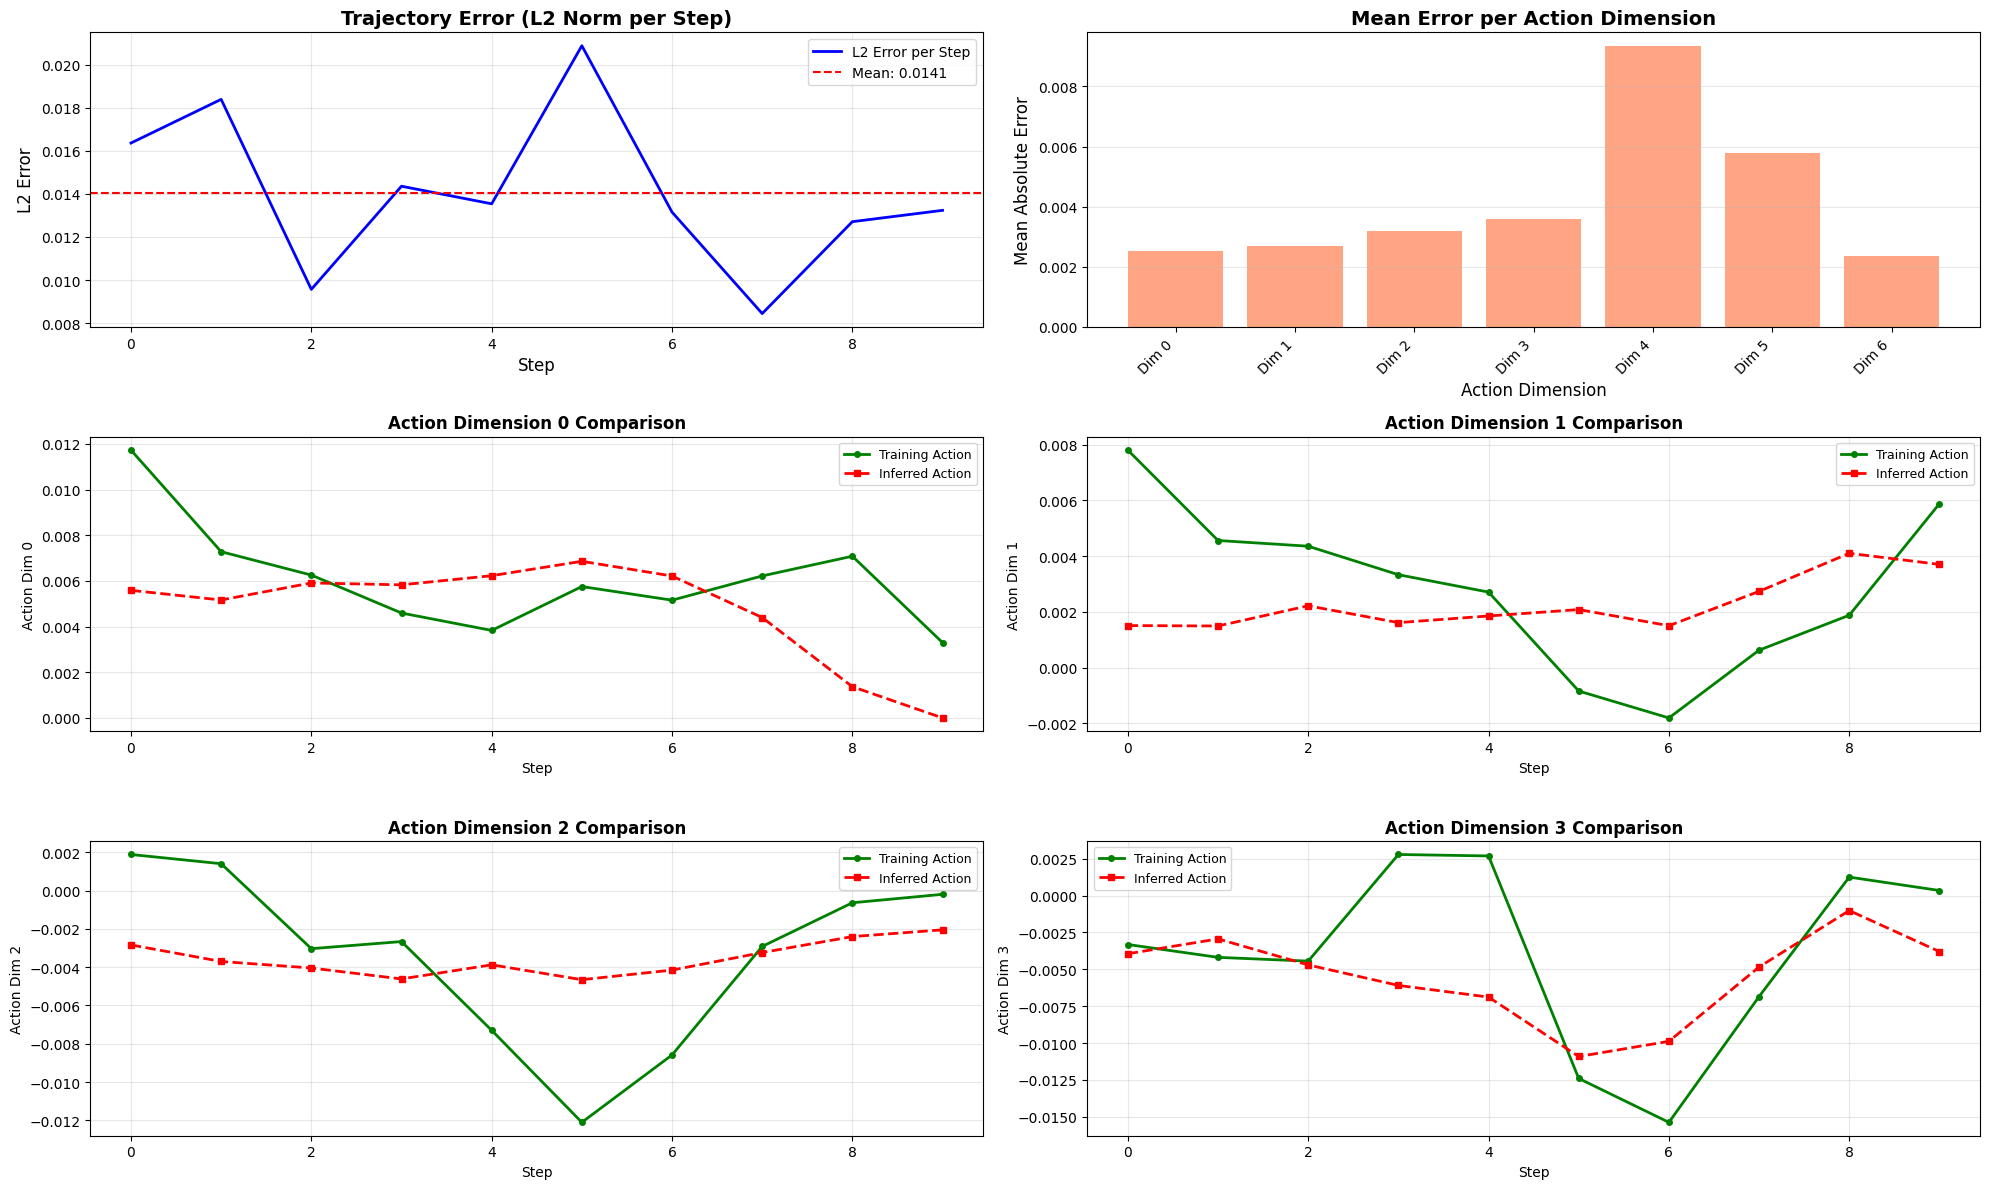

In [17]:
# 绘制对比图
fig = plt.figure(figsize=(20, 12))

# 1. 整体轨迹误差（L2 norm per step）
ax1 = plt.subplot(3, 2, 1)
ax1.plot(step_errors, 'b-', linewidth=2, label='L2 Error per Step')
ax1.axhline(y=mean_error, color='r', linestyle='--', linewidth=1.5, label=f'Mean: {mean_error:.4f}')
ax1.set_xlabel('Step', fontsize=12)
ax1.set_ylabel('L2 Error', fontsize=12)
ax1.set_title('Trajectory Error (L2 Norm per Step)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 每个维度的平均误差
ax2 = plt.subplot(3, 2, 2)
dim_names = [f'Dim {i}' for i in range(action_dim)]
bars = ax2.bar(dim_names, dim_mean_errors, color='coral', alpha=0.7)
ax2.set_xlabel('Action Dimension', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Error per Action Dimension', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3-4. 前几个维度的轨迹对比
num_dims_to_plot = min(4, action_dim)
for dim_idx in range(num_dims_to_plot):
    ax = plt.subplot(3, 2, 3 + dim_idx)
    steps = np.arange(min_steps)
    ax.plot(steps, training_actions_aligned[:, dim_idx], 'g-', linewidth=2, label='Training Action', marker='o', markersize=4)
    ax.plot(steps, inferred_actions_aligned[:, dim_idx], 'r--', linewidth=2, label='Inferred Action', marker='s', markersize=4)
    ax.set_xlabel('Step', fontsize=10)
    ax.set_ylabel(f'Action Dim {dim_idx}', fontsize=10)
    ax.set_title(f'Action Dimension {dim_idx} Comparison', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_inference_action_comparison.png', dpi=150, bbox_inches='tight')
print("✅ 图表已保存为: training_inference_action_comparison.png")
plt.show()


✅ 详细误差分析图已保存为: training_inference_action_error_analysis.png


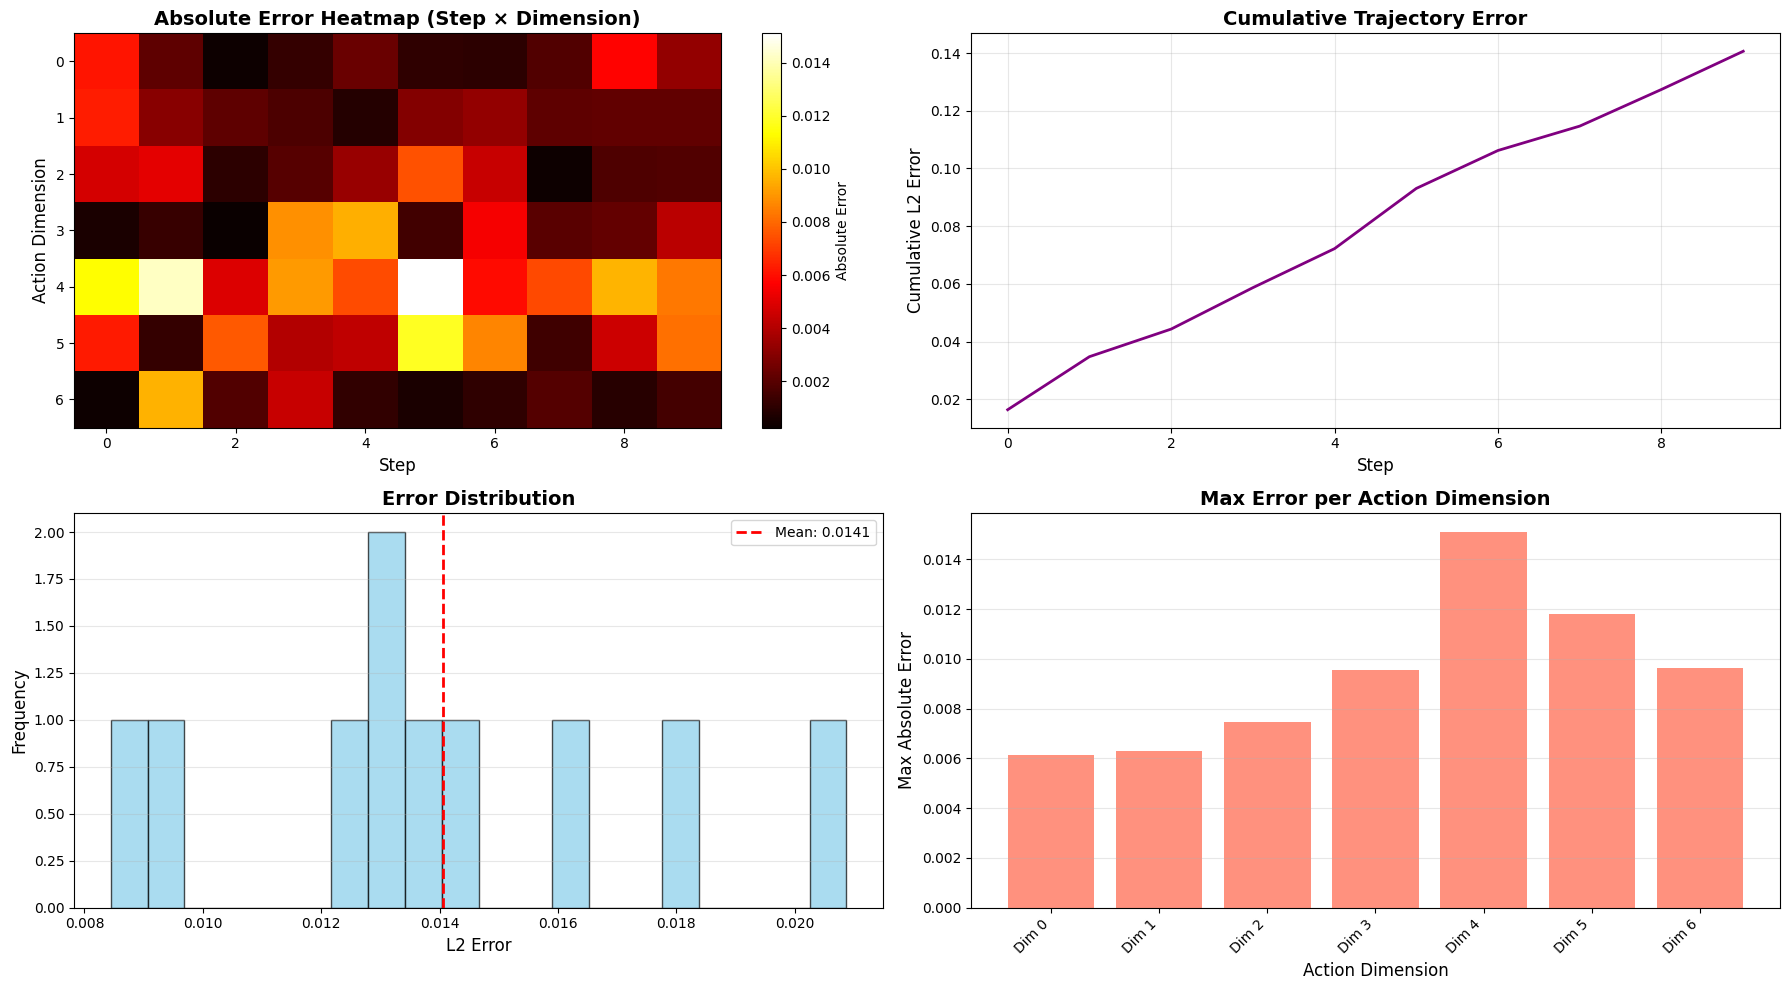

In [18]:
# 绘制更详细的误差分析图
fig2 = plt.figure(figsize=(18, 10))

# 1. 热力图：每个步骤每个维度的误差
ax1 = plt.subplot(2, 2, 1)
error_heatmap = np.abs(training_actions_aligned - inferred_actions_aligned)
im = ax1.imshow(error_heatmap.T, aspect='auto', cmap='hot', interpolation='nearest')
ax1.set_xlabel('Step', fontsize=12)
ax1.set_ylabel('Action Dimension', fontsize=12)
ax1.set_title('Absolute Error Heatmap (Step × Dimension)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax1, label='Absolute Error')

# 2. 累积误差
ax2 = plt.subplot(2, 2, 2)
cumulative_error = np.cumsum(step_errors)
ax2.plot(cumulative_error, 'purple', linewidth=2)
ax2.set_xlabel('Step', fontsize=12)
ax2.set_ylabel('Cumulative L2 Error', fontsize=12)
ax2.set_title('Cumulative Trajectory Error', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. 误差分布直方图
ax3 = plt.subplot(2, 2, 3)
ax3.hist(step_errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax3.axvline(x=mean_error, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_error:.4f}')
ax3.set_xlabel('L2 Error', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Error Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. 每个维度的最大误差
ax4 = plt.subplot(2, 2, 4)
bars = ax4.bar(dim_names, dim_max_errors, color='tomato', alpha=0.7)
ax4.set_xlabel('Action Dimension', fontsize=12)
ax4.set_ylabel('Max Absolute Error', fontsize=12)
ax4.set_title('Max Error per Action Dimension', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('training_inference_action_error_analysis.png', dpi=150, bbox_inches='tight')
print("✅ 详细误差分析图已保存为: training_inference_action_error_analysis.png")
plt.show()


In [19]:
# 打印详细的数值对比
print("=" * 80)
print("详细数值对比")
print("=" * 80)
print(f"\n样本索引: {sample_index}")
print(f"Prompt: {inference_input['prompt']}")
print(f"\n对比的步数: {min_steps}")
print(f"Action 维度: {action_dim}")

print(f"\n误差统计:")
print(f"  平均 L2 误差: {mean_error:.6f}")
print(f"  最大 L2 误差: {max_error:.6f}")
print(f"  最小 L2 误差: {min_error:.6f}")
print(f"  标准差: {np.std(step_errors):.6f}")

print(f"\n每个维度的平均绝对误差:")
for i in range(action_dim):
    print(f"  Dim {i:2d}: {dim_mean_errors[i]:.6f}")

print(f"\n每个维度的最大绝对误差:")
for i in range(action_dim):
    print(f"  Dim {i:2d}: {dim_max_errors[i]:.6f}")

# 保存数值结果到文件
output_file = "training_inference_action_comparison.txt"
with open(output_file, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("训练数据 vs 模型推理 Action 对比\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"样本索引: {sample_index}\n")
    f.write(f"Prompt: {inference_input['prompt']}\n")
    f.write(f"对比的步数: {min_steps}\n")
    f.write(f"Action 维度: {action_dim}\n\n")
    
    f.write("误差统计:\n")
    f.write(f"  平均 L2 误差: {mean_error:.6f}\n")
    f.write(f"  最大 L2 误差: {max_error:.6f}\n")
    f.write(f"  最小 L2 误差: {min_error:.6f}\n")
    f.write(f"  标准差: {np.std(step_errors):.6f}\n\n")
    
    f.write("每个维度的平均绝对误差:\n")
    for i in range(action_dim):
        f.write(f"  Dim {i:2d}: {dim_mean_errors[i]:.6f}\n")
    
    f.write("\n每个维度的最大绝对误差:\n")
    for i in range(action_dim):
        f.write(f"  Dim {i:2d}: {dim_max_errors[i]:.6f}\n")
    
    f.write("\n" + "=" * 80 + "\n")
    f.write("逐步骤详细对比:\n")
    f.write("=" * 80 + "\n")
    for step in range(min_steps):
        f.write(f"\nStep {step}:\n")
        f.write(f"  Training: {training_actions_aligned[step]}\n")
        f.write(f"  Inferred: {inferred_actions_aligned[step]}\n")
        f.write(f"  Error:    {np.abs(training_actions_aligned[step] - inferred_actions_aligned[step])}\n")
        f.write(f"  L2 Error: {step_errors[step]:.6f}\n")

print(f"\n✅ 详细数值结果已保存到: {output_file}")


详细数值对比

样本索引: 0
Prompt: pick blue bottle

对比的步数: 10
Action 维度: 7

误差统计:
  平均 L2 误差: 0.014062
  最大 L2 误差: 0.020874
  最小 L2 误差: 0.008446
  标准差: 0.003547

每个维度的平均绝对误差:
  Dim  0: 0.002523
  Dim  1: 0.002684
  Dim  2: 0.003204
  Dim  3: 0.003597
  Dim  4: 0.009333
  Dim  5: 0.005801
  Dim  6: 0.002357

每个维度的最大绝对误差:
  Dim  0: 0.006141
  Dim  1: 0.006300
  Dim  2: 0.007449
  Dim  3: 0.009567
  Dim  4: 0.015101
  Dim  5: 0.011824
  Dim  6: 0.009624

✅ 详细数值结果已保存到: training_inference_action_comparison.txt
